In [11]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings('ignore')

In [12]:
import nltk
nltk.download('all')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

In [14]:
# Setup some configuration parameters

config = {'min_text_len':40,
          'max_text_len':60,
          'max_summary_len':30,
          'latent_dim' : 300,
          'embedding_dim' : 200}

## Reading the dataset

In [16]:
df = pd.read_csv('news.csv')
df.head()

,summary,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [17]:
df.loc[0,'summary']

'upGrad learner switches to career in ML & Al with 90% salary hike'

In [18]:
df.loc[0,'text']

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [19]:
df.shape

(102915, 2)

### Filter text in the range between 40 and 60 words

In [20]:
df = df.loc[((df['text'].str.split(" ").str.len()>config['min_text_len'])
               &(df['text'].str.split(" ").str.len()<config['max_text_len']))].reset_index(drop=True)
print(f'After filtering: {df.shape}')

After filtering: (54572, 2)


##Text preprocessing

In [22]:
# Data Cleaning
def text_strip(sentence):

    sentence = re.sub("(\\t)", " ", str(sentence)).lower()
    sentence = re.sub("(\\r)", " ", str(sentence)).lower()
    sentence = re.sub("(\\n)", " ", str(sentence)).lower()

    # Remove - if it occurs more than one time consecutively
    sentence = re.sub("(--+)", " ", str(sentence)).lower()

    # Remove . if it occurs more than one time consecutively
    sentence = re.sub("(\.\.+)", " ", str(sentence)).lower()

    # Remove the characters - <>()|&©ø"',;?~*!
    sentence = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(sentence)).lower()

    # Remove \x9* in text
    sentence = re.sub(r"(\\x9\d)", " ", str(sentence)).lower()

    # Replace CM# and CHG# to CM_NUM
    sentence = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(sentence)).lower()

    # Remove punctuations at the end of a word
    sentence = re.sub("(\.\s+)", " ", str(sentence)).lower()
    sentence = re.sub("(\-\s+)", " ", str(sentence)).lower()
    sentence = re.sub("(\:\s+)", " ", str(sentence)).lower()

    # Remove multiple spaces
    sentence = re.sub("(\s+)", " ", str(sentence)).lower()

    return sentence

### Get the cleaned text and Add start, end tokens

In [23]:
df['cleaned_text'] = df.text.apply(lambda x: text_strip(x))
df['cleaned_summary'] = df.summary.apply(lambda x: '_START_ '+ text_strip(x) + ' _END_')

In [24]:
df = df[((df.cleaned_text.str.split().str.len()<=config['max_text_len']) &
                (df.summary.str.split().str.len()<=(config['max_summary_len']+4)))].copy()
df = df.reset_index(drop=True)
print(df.shape)

df = df.drop(['text', 'summary'], axis=1)
df = df.rename(columns = {'cleaned_text':'text',
                                      'cleaned_summary':'summary'})
df

(47500, 4)


,text,summary
0,pakistani singer rahat fateh ali khan has deni...,_START_ rahat fateh ali khan denies getting no...
1,india recorded their lowest odi total in new z...,_START_ india get all out for 92 their lowest ...
2,andhra pradesh cm n chandrababu naidu has said...,_START_ called pm modi sir 10 times to satisfy...
3,isha ghosh an 81-year-old member of bharat sco...,_START_ 81-yr-old woman conducts physical trai...
4,filmmaker karan johar and actress tabu turned ...,_START_ karan johar tabu turn showstoppers on ...
...,...,...
47495,indian captain virat kohli on friday got out w...,_START_ virat kohli out for a duck for first t...
47496,srinivas kunchubhotla 32 an indian engineer wa...,_START_ indian shot dead in us over alleged ra...
47497,an investigation by india today has unmasked a...,_START_ prosthetic fingers on sale to rig up e...
47498,a ticket collector on thursday allegedly bit o...,_START_ ticket collector bites off senior offi...


## Split the train and validation dataset

In [25]:
X_train, X_val, y_train, y_val = train_test_split(np.array(df["text"]),
                                            np.array(df["summary"]),
                                            test_size=0.1,
                                            random_state=0,
                                            shuffle=True
                                           )

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((42750,), (4750,), (42750,), (4750,))

In [26]:
def get_rare_words(text_col):

    # Prepare a tokenizer on testing data
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(list(text_col))
    # fit_on_texts() builds a vocabulary based on the words in text_col, counting the frequency of each word

    # word appearing less than 5 times is considered a rare word
    thresh = 5

    cnt = 0         # Counts the number of rare words
    tot_cnt = 0     # Total number of unique words

    for key, value in text_tokenizer.word_counts.items():
        tot_cnt = tot_cnt + 1
        if value < thresh:
            cnt = cnt + 1

    print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

    return cnt, tot_cnt

### Tokenize the input dataset

In [27]:
X_train_cnt, X_train_tot_cnt = get_rare_words(text_col=X_train)

% of rare words in vocabulary: 64.22363847045192


In [28]:
# Prepare a tokenizer by not considering the rare words
x_tokenizer = Tokenizer(num_words=X_train_tot_cnt - X_train_cnt)
x_tokenizer.fit_on_texts(list(X_train))

# Converts each sentence into a sequence of integers based on the tokenizer's vocabulary
x_tr_seq = x_tokenizer.texts_to_sequences(X_train)
x_val_seq = x_tokenizer.texts_to_sequences(X_val)

# pad_sequences() ensures that all sequences have the same length (max_text_len).
x_tr = pad_sequences(x_tr_seq,  maxlen=config['max_text_len'], padding='post')
x_val = pad_sequences(x_val_seq, maxlen=config['max_text_len'], padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print(f"Size of vocabulary in X = {x_voc}")

Size of vocabulary in X = 20996


### Tokenize the target

In [29]:
y_train_cnt, y_train_tot_cnt = get_rare_words(text_col=y_train)

% of rare words in vocabulary: 66.50248201023588


In [30]:
y_tokenizer = Tokenizer(num_words=y_train_tot_cnt - y_train_cnt)
y_tokenizer.fit_on_texts(list(y_train))

# Convert text sequences to integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

# Pad sequences upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=config['max_summary_len'], padding='post')
y_val = pad_sequences(y_val_seq, maxlen=config['max_summary_len'], padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print(f"Size of vocabulary in Y = {y_voc}")

Size of vocabulary in Y = 8706


### Initialize the Encoder and Decoder architecture

In [31]:
latent_dim = config['latent_dim']             # The number of units (neurons) in each LSTM layer
embedding_dim = config['embedding_dim']       # The size of the word embeddings
max_text_len = config['max_text_len']         # The maximum length of the input text sequence
max_summary_len = config['max_summary_len']   # The maximum length of the output summary sequence

# Encoder
# creates an input layer for the encoder that expects a sequence of word indices of length max_text_len
encoder_inputs = Input(shape=(max_text_len, ))


# Embedding layer
# Converts each word index into a dense vector of size embedding_dim using an embedding matrix
# trainable=True means the embedding weights will be updated during training
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)


# Three LSTM layers are stacked to increase the model's capacity
# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,       # returns both the output sequences and the final hidden & cell states
                     return_sequences=True, dropout=0.4,  # returns the full sequence of outputs
                     recurrent_dropout=0.4)               # dropout to the recurrent connections
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)


# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))


# Embedding layer
# Converts decoder word indices into embeddings
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)


# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)


(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])


# Dense layer
# TimeDistributed applies a dense layer at each time step to predict the next word
# softmax generate probability distributions over the vocabulary
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 60, 200)        │      4,199,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 60, 300),      │        601,200 │ embedding[0][0]        │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 60, 300),      │        721,200 │ lstm[0][0]             │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 200)      │      1,741,200 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 60, 300),      │        721,200 │ lstm_1[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 300),    │        601,200 │ embedding_1[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_2[0][1],          │
│                           │ 300)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 8706)     │      2,620,506 │ lstm_3[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,205,706 (42.75 MB)

 Trainable params: 11,205,706 (42.75 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and train the model

In [32]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_name = "./model.weights.h5"
model_check_point = tf.keras.callbacks.ModelCheckpoint(filepath=model_name,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [33]:
# the model expects 3D outputs hence reshaping is done to match this requirement

history = model.fit([x_tr, y_tr[:, :-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
                    epochs=10, callbacks=[early_stopping, model_check_point], batch_size=1024,
                    validation_data=([x_val, y_val[:, :-1]],
                    y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
                    )

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5839 - loss: 5.8822
Epoch 1: val_loss improved from inf to 2.53559, saving model to ./model.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5851 - loss: 5.8391 - val_accuracy: 0.6549 - val_loss: 2.5356
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6640 - loss: 2.5294
Epoch 2: val_loss improved from 2.53559 to 2.41649, saving model to ./model.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6643 - loss: 2.5288 - val_accuracy: 0.6957 - val_loss: 2.4165
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6910 - loss: 2.4446
Epoch 3: val_loss improved from 2.41649 to 2.38473, saving model to ./model.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6910 - loss: 2.4446 - val_accuracy: 0.6957 - val_loss: 2.3847
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6917 - loss: 2.4132
Epoch 4: val_loss improved from 2.38473 to 2.36028, saving model t

### Plot the train and validation loss

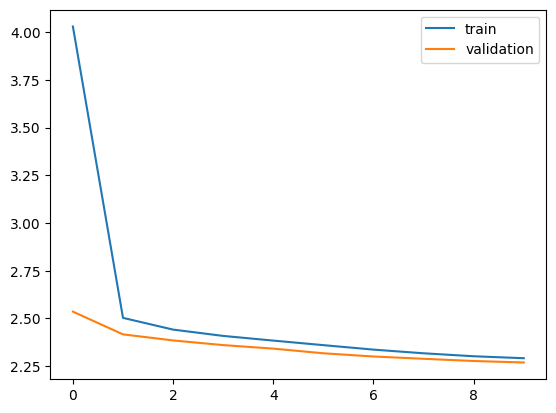

In [34]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

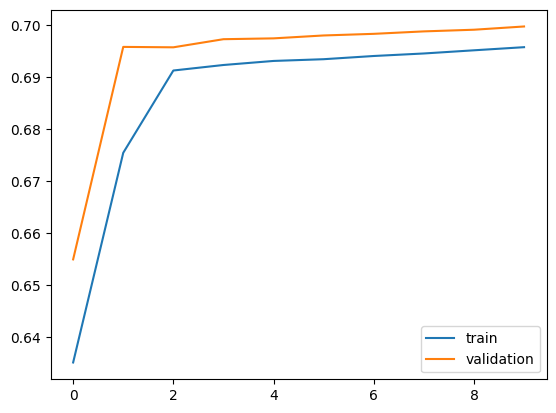

In [67]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()